#### Business problem

**Background:**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.


**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**age** : age of customer (numeric)

**job** : type of job (categorical)

**marital** : marital status (categorical)

**education** (categorical)

**default:** has credit in default? (binary)

**balance:** average yearly balance, in euros (numeric)

**housing:** has a housing loan? (binary)

**loan:** has personal loan? (binary)

**contact:** contact communication type (categorical)

**day:** last contact day of the month (numeric)

**month:** last contact month of year (categorical)

**duration:** last contact duration, in seconds (numeric)

**campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)

**Output (desired target):**

y - has the client subscribed to a term deposit? (binary)


**Goal(s):**

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

**Success Metric(s):**

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

**Bonus(es):**

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.
Submission Instructions:
Project should be implemented with Python
Please name your repository on GitHub with this name without exposing your project information: 2rpB77ZllGTkKyBM

In [136]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [137]:
# Import libraries and models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv('C:/Users/Tooman/Desktop/term-deposit-marketing-2020_data.csv')

## Data Exploration

In [138]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [139]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [140]:
print(df.shape)
print(df.size)

(40000, 14)
560000


### select only rows where the target is 'yes'

In [141]:
# select only rows where the target is y
t_df = df[df['y'] != 'no']

In [142]:
t_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
83,59,admin,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,yes
86,56,admin,married,secondary,no,45,no,no,unknown,5,may,1467,1,yes
87,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,yes
129,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,yes
168,54,admin,married,tertiary,no,184,no,no,unknown,5,may,673,2,yes


In [143]:
t_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2896.0,39.844959,11.001984,19.0,31.0,37.0,47.0,95.0
balance,2896.0,1588.495856,2924.894429,-3058.0,141.0,620.0,1820.5,45248.0
day,2896.0,15.827003,8.557604,1.0,8.0,16.0,22.0,31.0
duration,2896.0,682.958564,431.287174,8.0,364.0,629.0,913.0,3881.0
campaign,2896.0,2.414365,2.306015,1.0,1.0,2.0,3.0,32.0


**this helps to determine the customers we should go after by mean looking at the mean value of the features for customers that signed up to a term deposit.**

**We go back to analysis of the whole dataset.**

In [144]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


**Age:** Currently at an average of 40.54. This shows that most of the customers are in the middle age active business customers.

**Balance:** Average is at 1274.33. Most customers are making sizeable deosits into their accounts.

**Day:** Average of 16.01. Based on the circumstances, this may not be great as it takes longer to contact the customer.

**Duration:** Average of 255 seconds, is the amount of time customer was engaged at the last time of contact.

**Campaign:** Average of 2.88. The customers were contacted an average of 3 times during the campaign. 

In [145]:
# checks for missing values in the dataset
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [146]:
#check the unique values for all the categorical features

In [147]:
print(df['job'].unique()) #the unique values for the columns
print(df['marital'].unique()) #the unique values for the columns
print(df['education'].unique()) #the unique values for the columns
print(df['housing'].unique()) #the unique values for the columns
print(df['loan'].unique()) #the unique values for the columns
print(df['campaign'].unique()) #the unique values for the columns

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
['married' 'single' 'divorced']
['tertiary' 'secondary' 'unknown' 'primary']
['yes' 'no']
['no' 'yes']
[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]


In [148]:
df.corr()  #checks for the correlation of the variables against each other

,age,balance,day,duration,campaign
age,1.000000,0.081517,-0.011689,-0.036270,0.016204
balance,0.081517,1.000000,0.011662,0.014072,-0.008137
day,-0.011689,0.011662,1.000000,-0.032983,0.165429
duration,-0.036270,0.014072,-0.032983,1.000000,-0.088387
campaign,0.016204,-0.008137,0.165429,-0.088387,1.000000


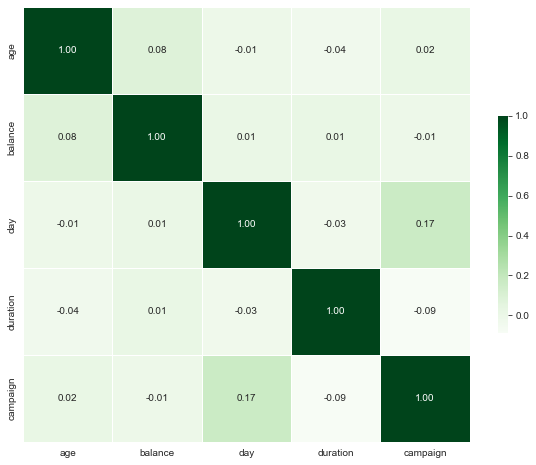

In [149]:
#plot correlation matrix heatmap
corr = df.corr()

sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='Greens', fmt=".2f", 
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

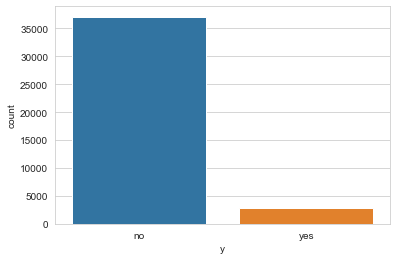

In [150]:
sns.countplot(df["y"],orient="V")
plt.show()

In [151]:
df['y'].value_counts(normalize=True)*100

no     92.76
yes     7.24
Name: y, dtype: float64

#### Distribution of numeric features

In [152]:
from matplotlib.ticker import StrMethodFormatter

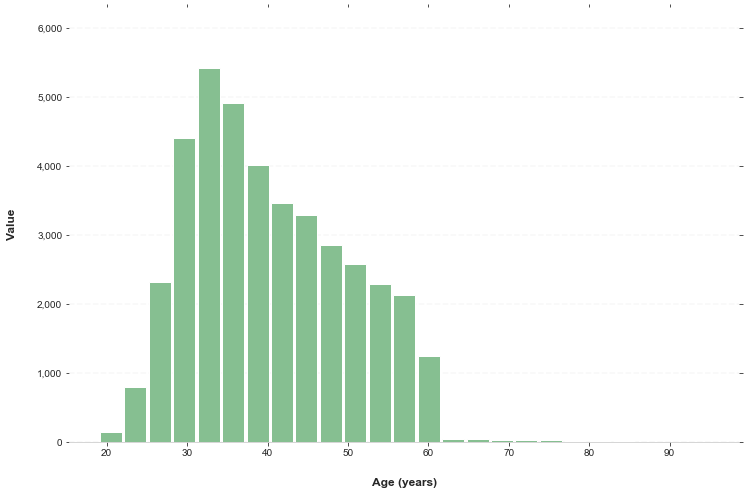

In [153]:
ax = df.hist(column='age', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Age (years)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Value", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

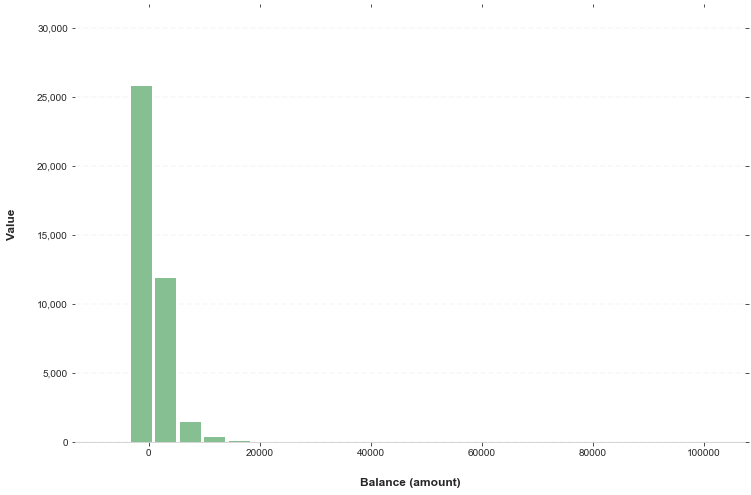

In [154]:
ax = df.hist(column='balance', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Balance (amount)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Value", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

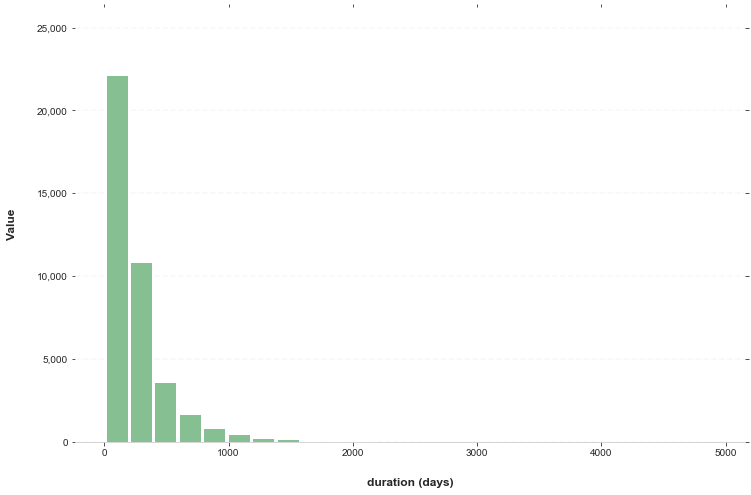

In [155]:
ax = df.hist(column='duration', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("duration (days)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Value", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

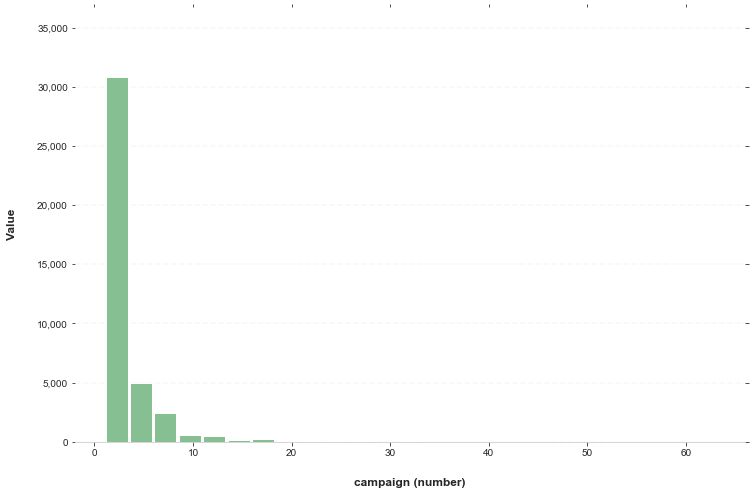

In [156]:
ax = df.hist(column='campaign', bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("campaign (number)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Value", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

#### Distribution of categorical features

Text(0.5, 1.0, 'Countplot example with titanic dataset')

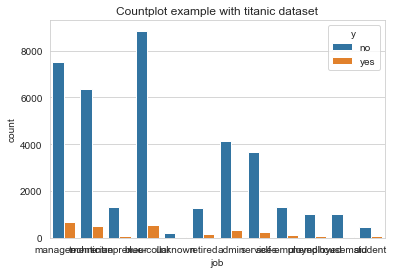

In [157]:
# Plot countplot
ax = sns.countplot(
                   x="job", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

Text(0.5, 1.0, 'Countplot example with titanic dataset')

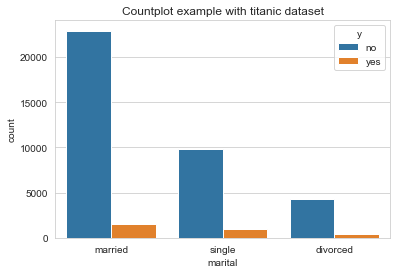

In [158]:
# Plot countplot
ax = sns.countplot(
                   x="marital", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

Text(0.5, 1.0, 'Countplot example with titanic dataset')

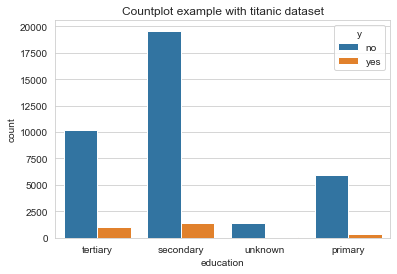

In [159]:

# Plot countplot
ax = sns.countplot(
                   x="education", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

Text(0.5, 1.0, 'Countplot example with titanic dataset')

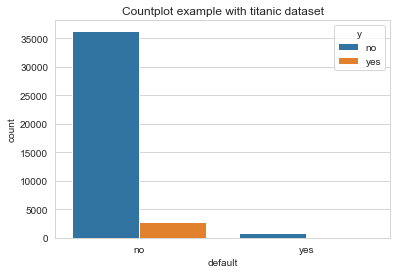

In [160]:
# Plot countplot
ax = sns.countplot(
                   x="default", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

Text(0.5, 1.0, 'Countplot example with titanic dataset')

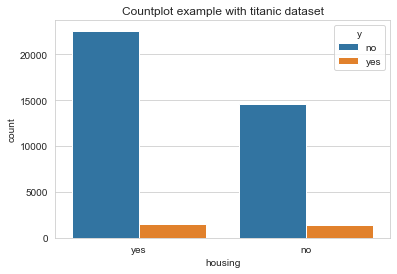

In [161]:
# Plot countplot
ax = sns.countplot(
                   x="housing", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

Text(0.5, 1.0, 'Countplot example with titanic dataset')

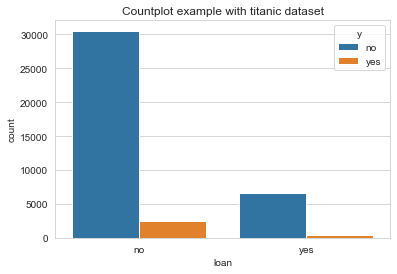

In [162]:
# Plot countplot
ax = sns.countplot(
                   x="loan", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

Text(0.5, 1.0, 'Countplot example with titanic dataset')

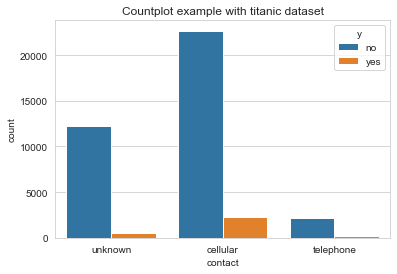

In [163]:
# Plot countplot
ax = sns.countplot(
                   x="contact", 
                   data=df, 
                   hue='y') 
# Set title
plt.title("Countplot example with titanic dataset") 

#### Encode categorical variables

In [164]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

In [165]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [166]:
label_encoder = LabelEncoder()
df['job'] = label_encoder.fit_transform(df['job'])
df['marital'] = label_encoder.fit_transform(df['marital'])
df['education'] = label_encoder.fit_transform(df['education'])
df['default'] = label_encoder.fit_transform(df['default'])
df['housing'] = label_encoder.fit_transform(df['housing'])
df['loan'] = label_encoder.fit_transform(df['loan'])
df['contact'] = label_encoder.fit_transform(df['contact'])
df['month'] = label_encoder.fit_transform(df['month'])
#df['y'] = label_encoder.fit_transform(df['y'])

In [167]:
df['y'].replace({'no': 0, 'yes':1}, inplace=True)

In [168]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,0


## Modelling

In [169]:
# define dataset features
features = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign']

X = df.loc[:, features]
y = df.loc[:, ['y']]

**Split Data**

In [170]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

**Scale the Data with Standard Scaler**

In [171]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [172]:
#define sample weight based on proportion
df['y'].value_counts()

0    37104
1     2896
Name: y, dtype: int64

In [173]:
weight = 37104/2896
print(weight)

12.812154696132596


#### RandomForest Classifier with imbalanced data

In [174]:
rf_classifier = RandomForestClassifier()

In [175]:
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [176]:
rf_pred = rf_classifier.predict(X_train_scaled)

In [177]:
print(classification_report(y_train, rf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29683
           1       1.00      1.00      1.00      2317

    accuracy                           1.00     32000
   macro avg       1.00      1.00      1.00     32000
weighted avg       1.00      1.00      1.00     32000



In [178]:
y_pred = rf_classifier.predict(X_test_scaled)
y_train_pred = rf_classifier.predict(X_train_scaled)

In [179]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

1.0
0.93825
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7421
           1       0.64      0.34      0.44       579

    accuracy                           0.94      8000
   macro avg       0.79      0.66      0.70      8000
weighted avg       0.93      0.94      0.93      8000



In [180]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

In [181]:
# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [182]:
# evaluate model
#scores = cross_val_score(rf_classifier, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

In [183]:
# summarize performance
#print('Mean ROC AUC: %.3f' % mean(scores))

In [184]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=5, scoring='accuracy')

# Calculate and report the average performance score
average_score = np.mean(scores)
print(f'Average Performance Score: {average_score}')

Average Performance Score: 0.934375


In [185]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=5, scoring='roc_auc')

# Calculate and report the average performance score
average_score = np.mean(scores)
print(f'Average Performance Score: {average_score}')

Average Performance Score: 0.9297524219934195


In [186]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=5, scoring='f1')

# Calculate and report the average performance score
average_score = np.mean(scores)
print(f'Average Performance Score: {average_score}')

Average Performance Score: 0.3645361227461512


#### Random Forest Classifier with weighted balancing

In [187]:
rf_classifier = RandomForestClassifier(max_depth=2, random_state=42, class_weight = {0: 1, 1: weight})

In [188]:
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 12.812154696132596}, max_depth=2,
                       random_state=42)

In [189]:
rf_pred = rf_classifier.predict(X_train_scaled)

In [190]:
print(classification_report(y_train, rf_pred))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     29683
           1       0.31      0.81      0.45      2317

    accuracy                           0.86     32000
   macro avg       0.65      0.83      0.68     32000
weighted avg       0.93      0.86      0.88     32000



In [191]:
y_pred = rf_classifier.predict(X_test_scaled)
y_train_pred = rf_classifier.predict(X_train_scaled)

In [192]:
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.85784375
0.859
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7421
           1       0.31      0.80      0.45       579

    accuracy                           0.86      8000
   macro avg       0.65      0.83      0.68      8000
weighted avg       0.93      0.86      0.89      8000



##### Perform 5-fold cross-validation

In [193]:
# define evaluation procedure
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
# evaluate model
#scores = cross_val_score(rf_classifier, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
#print('Mean ROC AUC: %.3f' % mean(scores))

In [194]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=5, scoring='accuracy')

# Calculate and report the average performance score
average_score = np.mean(scores)
print(f'Average Performance Score: {average_score}')

Average Performance Score: 0.866625


In [195]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=5, scoring='roc_auc')

# Calculate and report the average performance score
average_score = np.mean(scores)
print(f'Average Performance Score: {average_score}')

Average Performance Score: 0.8961601003692387


In [196]:
# Perform 5-fold cross-validation
scores = cross_val_score(rf_classifier, X_test_scaled, y_test, cv=5, scoring='f1')

# Calculate and report the average performance score
average_score = np.mean(scores)
print(f'Average Performance Score: {average_score}')

Average Performance Score: 0.4584384735061337


##### Plot the ROC and AUC Curves to check the strength of model

In [197]:
# Get the probability scores for the testing set
y_score = rf_classifier.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Calculate the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc = average_precision_score(y_test, y_score)

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

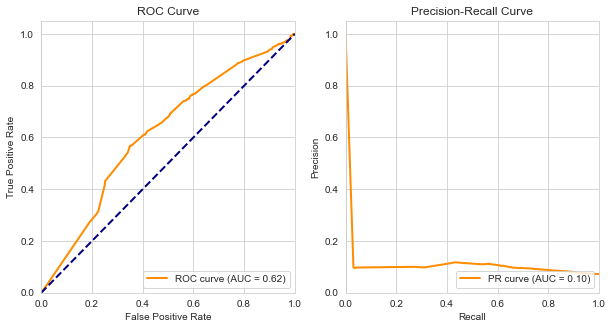

In [198]:
# Plot the Precision-Recall curve
plt.subplot(1,2,2)
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**RandomForest Classifier Feature importance Selection**

Text(0.5, 1.0, 'Feature Importance')

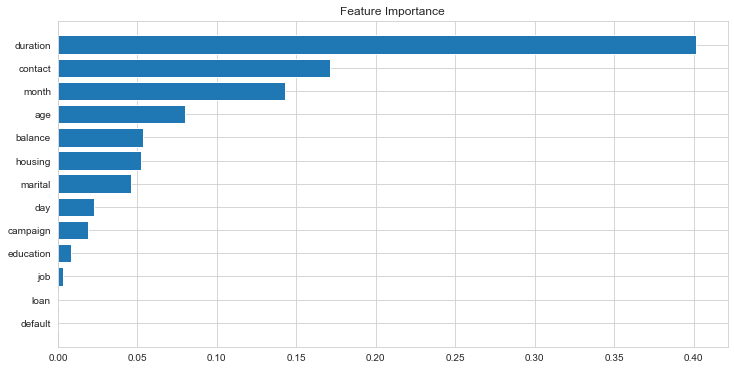

In [131]:
feature_importance = rf_classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

**Feature Importance Analysis:** 

According to this default parameter RandomForest Model, from the most to least important features is duration, contact, month, age, balance, housing, marital, day, campaign, education, job, loan, default. This will help in selecting features for the final model.

**Feature Selection:** 

Out of all the features in the dataset, some do not seem as if they would help predict the target value. For this first round I will remove all features except age, marital, balance, housing, contact, month, duration as these have the most correlation with the target prediction, and also have the highest feature importance from the RandomForest model.

In [132]:
#choose reduced number of features
features = ['age', 'marital', 'balance', 'housing', 'contact', 'month', 'duration'] 

X = df.loc[:, features]
y = df.loc[:, ['y']]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Retry Fitting RandomForest on new smaller feature set:**

In [133]:
rf_classifier = RandomForestClassifier(max_depth=2, random_state=42, class_weight = {0: 1, 1: weight})

rf_classifier.fit(X_train_scaled,y_train)

y_pred = rf_classifier.predict(X_test_scaled)
y_train_pred = rf_classifier.predict(X_train_scaled)
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.85846875
0.858875
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7421
           1       0.31      0.78      0.44       579

    accuracy                           0.86      8000
   macro avg       0.65      0.82      0.68      8000
weighted avg       0.93      0.86      0.88      8000



##### Using most important eatures did not improve the model accuracy. this is because the random forest model has already chosen the best features and applying feature importance did not make any improvement.